<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/BlackHole/blob/main/BlackHole_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/Black_Hole')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix, cohen_kappa_score, matthews_corrcoef, roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import load_model
import warnings
from rdkit import RDLogger
from tensorflow.keras import models, layers, regularizers
from sklearn.metrics import accuracy_score
import time
from tensorflow.keras.callbacks import EarlyStopping

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Additionally, suppress RDKit warnings globally
RDLogger.DisableLog('rdApp.*')

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)  # Return an array of zeros in case of an error

def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentage accuracy for each element in the confusion matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Combine counts and percentages for display
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_percentage[i, j]
            annot[i, j] = f'{c}\n({p:.1f}%)'  # Count and percentage

    # Plot the confusion matrix with annotations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def preprocess_graph(graph, features):
    # Determine the dimensionality of the feature vectors
    feature_dimension = features.shape[1]

    # Convert the graph to an adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(graph).toarray()

    # Initialize an empty list to store feature vectors
    feature_vectors = []

    # Create a mapping from node labels to integer indices
    node_to_index = {node: index for index, node in enumerate(graph.nodes())}

    # Iterate over nodes in the graph
    for node in graph.nodes():
        # Get the integer index corresponding to the node label
        node_index = node_to_index[node]
        # Check if the node index is valid
        if node_index < len(features):
            # Append the feature vector corresponding to the node index
            feature_vectors.append(features[node_index])
        else:
            # If the node index is out of range, assign a default feature vector
            feature_vectors.append(np.zeros((feature_dimension,)))

    # Convert the list of feature vectors to a numpy array
    feature_matrix = np.array(feature_vectors)

    return adjacency_matrix, feature_matrix

def build_gcn_model(input_shape_feature, input_shape_adjacency, num_classes):
    # Define input layers
    x_inp_feature = Input(shape=(input_shape_feature,))
    x_inp_adjacency = Input(shape=(input_shape_adjacency,))

    # Feature processing with multiple layers
    x_feature = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_inp_feature)
    x_feature = Dropout(0.5)(x_feature)
    x_feature = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x_feature)
    x_feature = Dropout(0.3)(x_feature)

    # Adjacency processing with multiple layers
    x_adjacency = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_inp_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)
    x_adjacency = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x_adjacency)
    x_adjacency = Dropout(0.3)(x_adjacency)

    # Concatenate feature and adjacency outputs
    x = concatenate([x_feature, x_adjacency])

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[x_inp_feature, x_inp_adjacency], outputs=output)

    # Using a smaller learning rate
    optimizer = Adam(learning_rate=0.0009)

    # Compile model
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    return model

def build_feedforward_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_gcn_model(model, adjacency_matrix, feature_matrix, labels, epochs, batch_size):
    if model is not None and adjacency_matrix is not None and feature_matrix is not None and labels is not None:
        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # ModelCheckpoint to save the best model
        model_checkpoint = ModelCheckpoint('best_gcn_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

        start_time = time.time()
        # Train the model
        history = model.fit([feature_matrix, adjacency_matrix], labels,
                            epochs=epochs, batch_size=batch_size,
                            validation_split=0.2, callbacks=[early_stopping, model_checkpoint])
        end_time = time.time()

        # Calculate total training time
        total_training_time = end_time - start_time
        print(f"Total training time: {total_training_time:.2f} seconds")

        return history
    else:
        print("Error: One or more input arguments to train_gcn_model is None.")


from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    edge_list_filenames = [
        'sparsified_graph_edges_blackhole_0.1.csv',
        'sparsified_graph_edges_blackhole_0.2.csv',
        'sparsified_graph_edges_blackhole_0.3.csv',
        'sparsified_graph_edges_blackhole_0.4.csv',
        'sparsified_graph_edges_blackhole_0.5.csv',
        'sparsified_graph_edges_blackhole_0.6.csv',
        'sparsified_graph_edges_blackhole_0.7.csv',
        'sparsified_graph_edges_blackhole_0.8.csv',
        'sparsified_graph_edges_blackhole_0.9.csv'
    ]

    summary_data_filename = '1M1L3D_summary.csv'

    # Initialize lists to track accuracies and thresholds
    accuracies = []
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    # Loop through all edge list files
    for edges_list_filename, threshold in zip(edge_list_filenames, thresholds):
        print(f"Processing edge list file: {edges_list_filename}")

        # Load data
        edges_list = pd.read_csv(edges_list_filename, header=None, names=['source', 'target', 'weight'], delimiter=' ')
        summary_data = pd.read_csv(summary_data_filename)

        node_labels_source = edges_list['source'].astype(str).unique()
        node_labels_target = edges_list['target'].astype(str).unique()
        node_labels = np.unique(np.concatenate((node_labels_source, node_labels_target)))
        node_labels = list(set(node_labels))

        print("Unique node labels:", len(node_labels))

        summary_data_filtered = summary_data[summary_data['refcode'].isin(node_labels)]
        print("Filtered summary data:\n", len(summary_data_filtered))

        if not summary_data_filtered.empty:
            linker_smiles = summary_data_filtered['linker SMILES']
            if not linker_smiles.empty:
                # Generate features
                linker_features = np.stack(linker_smiles.dropna().apply(generate_fingerprint).values)
                metal_names = summary_data_filtered['metal']
                metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)

                other_features = summary_data_filtered[['Largest Cavity Diameter', 'Largest Free Sphere']].values.astype('float32')
                features = np.concatenate((linker_features, metal_features, other_features), axis=1)

                # Generate labels
                summary_data_filtered['PLD_category'] = pd.cut(
                    summary_data_filtered['Pore Limiting Diameter'],
                    bins=[-np.inf, 2.4, 4.4, 5.9, np.inf],
                    labels=['nonporous', 'small pore', 'medium pore', 'large pore']
                )
                labels = pd.get_dummies(summary_data_filtered['PLD_category']).values

                # Split the data into training and testing sets
                X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=56)

                # Load the sparsified graph
                graph = nx.read_weighted_edgelist(edges_list_filename)

                # Preprocess the graph data
                adjacency_matrix, feature_matrix = preprocess_graph(graph, features)

                # Split the adjacency and feature matrices accordingly
                adj_train, adj_test, feat_train, feat_test = train_test_split(adjacency_matrix, feature_matrix, test_size=0.2, random_state=56)

                # Provide the number of classes
                num_classes = labels.shape[1]

                # Build the GCN model
                gcn_model = build_gcn_model(feat_train.shape[1], adj_train.shape[1], num_classes)

                # Train the GCN model
                history = train_gcn_model(gcn_model, adj_train, feat_train, y_train, epochs=40, batch_size=32)

                # Evaluate the model on the test set
                test_loss, test_accuracy = gcn_model.evaluate([feat_test, adj_test], y_test, verbose=0)
                print(f'Test Accuracy for threshold {threshold}: {test_accuracy}')

                # Track the accuracy
                accuracies.append(test_accuracy)

                # Continue with your evaluation metrics and comparison logic
                # ...
            else:
                print("Error: linker_smiles column is empty.")
        else:
            print("Error: summary_data_filtered DataFrame is empty.")

    # Plot the accuracy comparison
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, marker='o', color='b', label='Test Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('GCN Test Accuracy Across Different Sparsification Thresholds')
    plt.grid(True)
    plt.legend()
    plt.show()


ModuleNotFoundError: No module named 'rdkit'

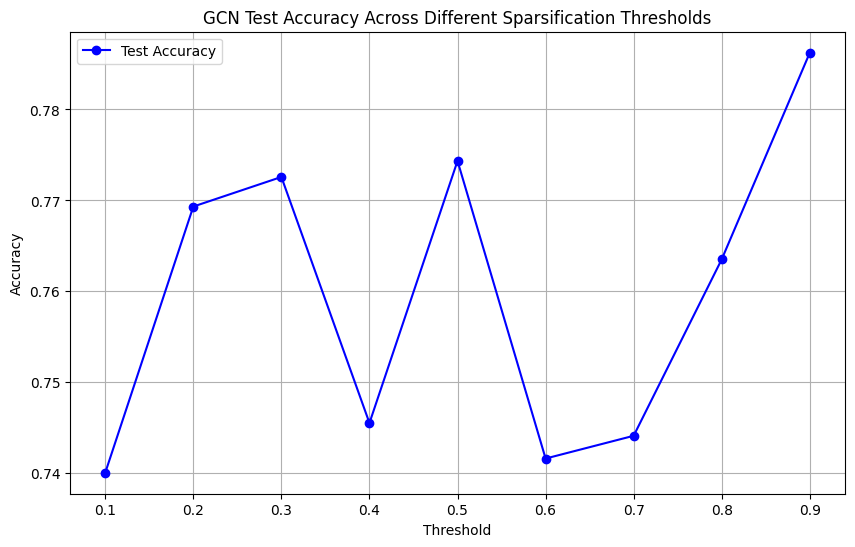

**Evaluation on Cintinius PLD**

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from rdkit import RDLogger

# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)  # Return an array of zeros in case of an error

def preprocess_graph(graph, features):
    """Preprocesses graph data into adjacency and feature matrices."""
    feature_dimension = features.shape[1]
    adjacency_matrix = nx.adjacency_matrix(graph).toarray()
    feature_vectors = []

    node_to_index = {node: index for index, node in enumerate(graph.nodes())}
    for node in graph.nodes():
        node_index = node_to_index[node]
        if node_index < len(features):
            feature_vectors.append(features[node_index])
        else:
            feature_vectors.append(np.zeros((feature_dimension,)))

    feature_matrix = np.array(feature_vectors)
    return adjacency_matrix, feature_matrix

def build_gcn_model(input_shape_feature, input_shape_adjacency):
    """Builds a Graph Convolutional Network model for regression."""
    x_inp_feature = Input(shape=(input_shape_feature,))
    x_inp_adjacency = Input(shape=(input_shape_adjacency,))

    x_feature = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_inp_feature)
    x_feature = Dropout(0.5)(x_feature)
    x_feature = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x_feature)
    x_feature = Dropout(0.5)(x_feature)

    x_adjacency = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x_inp_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)
    x_adjacency = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)

    x = concatenate([x_feature, x_adjacency])
    output = Dense(1)(x)  # Single output node for regression

    model = Model(inputs=[x_inp_feature, x_inp_adjacency], outputs=output)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    return model

def train_gcn_model(model, adjacency_matrix, feature_matrix, labels, epochs, batch_size):
    """Trains the GCN model and returns the training history."""
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_gcn_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit([feature_matrix, adjacency_matrix], labels,
                        epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, callbacks=[early_stopping, model_checkpoint])
    return history

if __name__ == "__main__":
    # Load your data
    edge_list_filename = 'sparsified_graph_edges_blackhole_0.1.csv'
    summary_data_filename = '1M1L3D_summary.csv'


    edges_list = pd.read_csv(edge_list_filename, header=None, names=['source', 'target', 'weight'], delimiter=' ')
    summary_data = pd.read_csv(summary_data_filename)

    node_labels_source = edges_list['source'].astype(str).unique()
    node_labels_target = edges_list['target'].astype(str).unique()
    node_labels = np.unique(np.concatenate((node_labels_source, node_labels_target)))

    summary_data_filtered = summary_data[summary_data['refcode'].isin(node_labels)]

    linker_smiles = summary_data_filtered['linker SMILES']
    linker_features = np.stack(linker_smiles.dropna().apply(generate_fingerprint).values)

    features = linker_features
    labels = summary_data_filtered['Pore Limiting Diameter'].values

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    graph = nx.read_weighted_edgelist(edge_list_filename)
    adjacency_matrix, feature_matrix = preprocess_graph(graph, features)

    adj_train, adj_test, feat_train, feat_test = train_test_split(adjacency_matrix, feature_matrix, test_size=0.2, random_state=42)

    model = build_gcn_model(feat_train.shape[1], adj_train.shape[1])
    history = train_gcn_model(model, adj_train, feat_train, y_train, epochs=50, batch_size=32)

    test_loss, test_rmse = model.evaluate([feat_test, adj_test], y_test, verbose=0)
    print(f'Test RMSE: {test_rmse}')


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 23.7612 - root_mean_squared_error: 4.2479
Epoch 1: val_loss improved from inf to 13.58128, saving model to best_gcn_model.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 23.7418 - root_mean_squared_error: 4.2460 - val_loss: 13.5813 - val_root_mean_squared_error: 3.0445
Epoch 2/50
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.3102 - root_mean_squared_error: 3.0263
Epoch 2: val_loss improved from 13.58128 to 10.56723, saving model to best_gcn_model.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 13.3053 - root_mean_squared_error: 3.0258 - val_loss: 10.5672 - val_root_mean_squared_error: 2.6190
Epoch 3/50
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 11.6582 - root_mean_squared_error: 2.8310
Epoch 3: val_loss improved from 10.56723 to 9.78767, saving model to best_gcn_model.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 11.6522 - root_mean_squared_error: 2.8302 - val_loss: 9.7877 - val_root_me

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
import warnings
from rdkit import RDLogger

# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)

def load_and_preprocess_data(filename):
    """Load and preprocess data."""
    summary_data = pd.read_csv(filename)
    summary_data_filtered = summary_data.dropna(subset=['linker SMILES', 'Pore Limiting Diameter'])

    linker_smiles = summary_data_filtered['linker SMILES']
    features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    labels = summary_data_filtered['Pore Limiting Diameter'].values

    return features, labels

def train_and_evaluate_model(features, labels, model):
    """Splits data, trains model, and evaluates it."""
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Feature scaling for KNN
    if isinstance(model, KNeighborsRegressor):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

if __name__ == "__main__":
    features, labels = load_and_preprocess_data('filtered_summary_data.csv')

    # K-Nearest Neighbors Regressor
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_rmse = train_and_evaluate_model(features, labels, knn_model)
    print(f'KNN RMSE: {knn_rmse}')

    # Gradient Boosting Trees Regressor
    gbtree_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbtree_rmse = train_and_evaluate_model(features, labels, gbtree_model)
    print(f'GBTree RMSE: {gbtree_rmse}')


KNN RMSE: 2.2503007682787586
GBTree RMSE: 2.1923753956354797


**Data Filtering Description**

Objective: Filter entries from the dataset 1M1L3D_summary.csv based on matching refcode values found in either the source or target columns of the edge list sparsified_graph_edges_blackhole_0.1.csv. The edge list file is formatted without headers and uses spaces as delimiters.



Read both datasets; the summary data with headers, and the edge list as a headerless space-delimited file.
Extract and combine unique refcode values from both source and target columns of the edge list.
Filter the summary data to retain only rows whose refcode is in the list of extracted unique codes.
Save the filtered data to a new CSV for further analysis.
Outcome: This process ensures the summary dataset only contains records relevant to the connections defined in the edge list, facilitating targeted data analysis.

In [ ]:
import pandas as pd

# Load the data from the files
summary_data = pd.read_csv('1M1L3D_summary.csv')
edge_list = pd.read_csv('sparsified_graph_edges_blackhole_0.1.csv', delim_whitespace=True, header=None, names=['source', 'target', 'weight'])

# Find unique refcodes in both 'source' and 'target' columns of the edge list
unique_refcodes = pd.concat([edge_list['source'], edge_list['target']]).unique()

# Filter the summary data to keep only rows where 'refcode' is in the list of unique refcodes
filtered_summary_data = summary_data[summary_data['refcode'].isin(unique_refcodes)]

# Save the filtered data to a new CSV file
filtered_summary_data.to_csv('filtered_summary_data.csv', index=False)



<ipython-input-22-026642167ec6>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('viridis', num_communities)


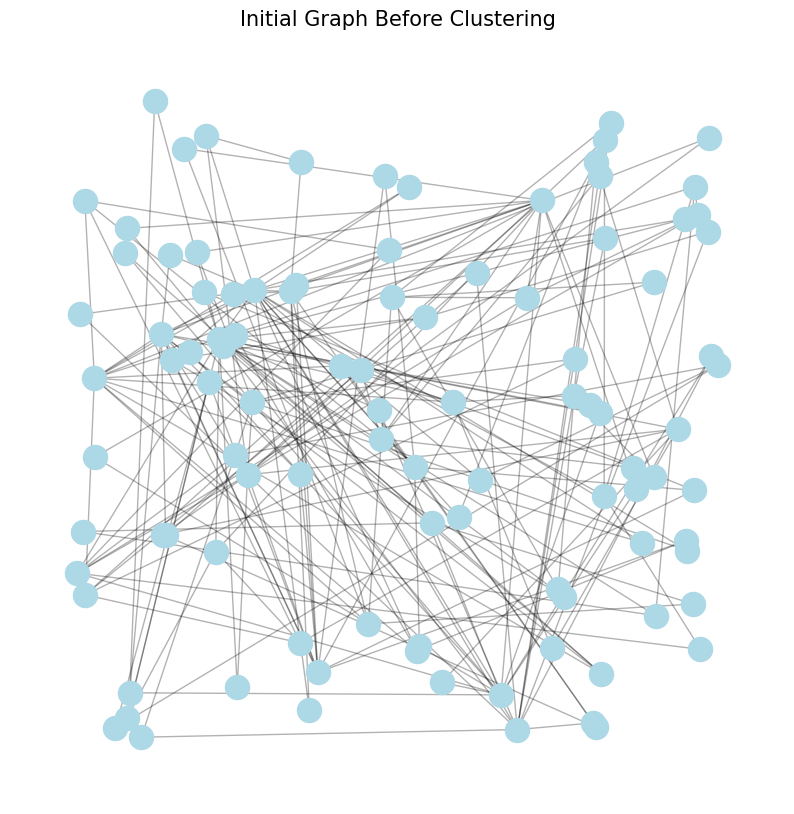

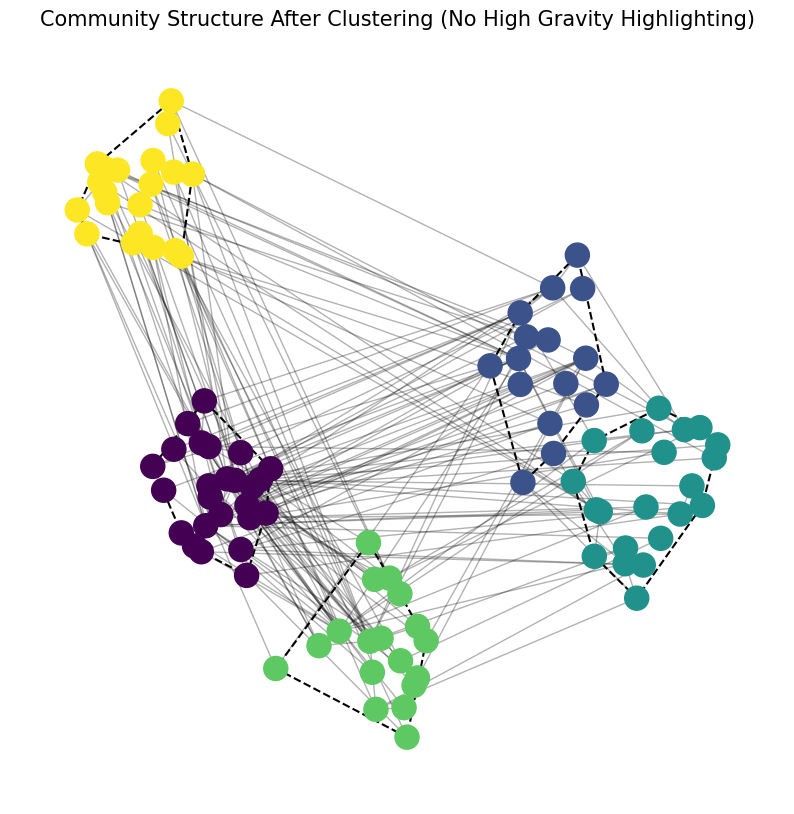

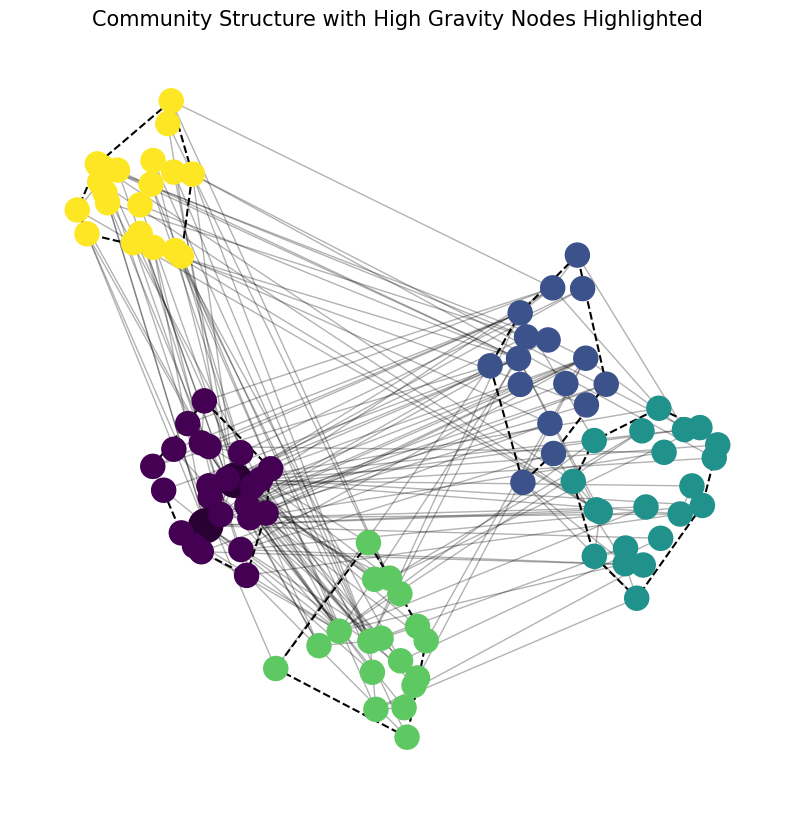

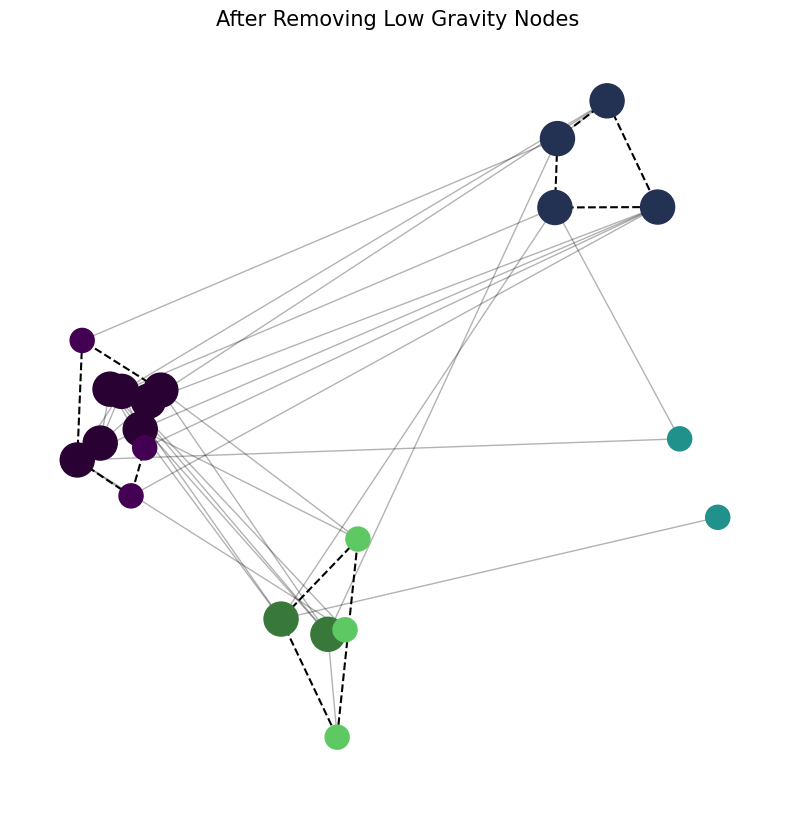

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

# Step 1: Create a random graph with 100 nodes using the Barabási-Albert model
G = nx.barabasi_albert_graph(100, 2)  # 100 nodes, each new node connects to 2 existing nodes

# Step 2: Assign random communities to nodes
communities = {node: random.randint(1, 5) for node in G.nodes()}  # 5 different communities
unique_communities = sorted(set(communities.values()))
num_communities = len(unique_communities)

# Create a mapping from community number to index (0 to num_communities-1)
community_to_index = {community: idx for idx, community in enumerate(unique_communities)}

# Use a colormap to assign colors to communities
color_map = cm.get_cmap('viridis', num_communities)
community_colors = {community: color_map(community_to_index[community] / num_communities)
                    for community in unique_communities}

# Step 3: Calculate centrality (used as gravity measure)
centrality = nx.degree_centrality(G)

# Function to darken a color
def darken_color(color, factor=0.6):
    """
    Darkens an RGB color by the given factor.
    Args:
        color (tuple): RGBA color tuple.
        factor (float): Factor by which to darken the color (0 < factor < 1).
    Returns:
        tuple: Darkened RGBA color tuple.
    """
    return tuple([c * factor for c in color[:3]] + [color[3]])

# Function to separate communities in the plot
def separate_communities_layout(G, communities, scale=3):
    """
    Position nodes in different communities separately, but do it only once.
    """
    pos = nx.spring_layout(G, seed=42)  # Start with a spring layout

    # Get unique communities
    unique_communities = set(communities.values())

    # Define offsets for each community to separate them spatially
    offset_dict = {community: (random.uniform(-scale, scale), random.uniform(-scale, scale))
                   for community in unique_communities}

    # Apply the offset to each node's position based on its community
    for node in G.nodes():
        community = communities[node]
        pos[node] = (pos[node][0] + offset_dict[community][0], pos[node][1] + offset_dict[community][1])

    return pos

# Function to plot the graph without any clustering (Initial Step)
def plot_initial_graph(G, title):
    pos_random = nx.random_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos_random, node_size=300, node_color="lightblue")
    nx.draw_networkx_edges(G, pos_random, alpha=0.3)
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Step 4: Plot the graph with community colors, separated positions, and community boundaries
def plot_graph_with_community_boundaries(G, node_size, node_color, title, pos, communities):
    plt.figure(figsize=(10, 10))

    # Plot the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw a boundary around each community using Convex Hull
    for community in set(communities.values()):
        # Extract the nodes in this community
        community_nodes = [node for node in G.nodes() if communities[node] == community]

        # Get the positions of the community nodes
        points = np.array([pos[node] for node in community_nodes])

        if len(points) > 2:  # ConvexHull needs at least 3 points
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]

            # Create a polygon patch around the convex hull
            polygon = Polygon(hull_points, fill=False, edgecolor='black', linewidth=1.5, linestyle='--')
            plt.gca().add_patch(polygon)

    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Step 5: Compute node positions ONCE
pos = separate_communities_layout(G, communities)  # Compute and reuse these positions

# Step 6: Plot the graph before clustering (Initial Step)
plot_initial_graph(G, "Initial Graph Before Clustering")

# Step 7: Prepare colors and node sizes for the second plot (Community Separation)
colors = [community_colors[communities[node]] for node in G.nodes()]
node_sizes = [300 for node in G.nodes()]  # Uniform size for the initial community separation plot

# Plot with separated communities (No High Gravity Highlighting)
plot_graph_with_community_boundaries(G, node_sizes, colors, "Community Structure After Clustering (No High Gravity Highlighting)", pos, communities)

# Step 8: Identify high gravity nodes
gravity_threshold = 0.15  # Threshold to define "high gravity" nodes
high_gravity_nodes = {node for node, cent in centrality.items() if cent > gravity_threshold}

# Prepare colors and node sizes for the third plot (After Highlighting High Gravity Nodes)
colors = []
for node in G.nodes():
    base_color = community_colors[communities[node]]
    if node in high_gravity_nodes:
        # Darken the color for high gravity nodes
        dark_color = darken_color(base_color, factor=0.6)
        colors.append(dark_color)
    else:
        colors.append(base_color)

node_sizes = [300 if node not in high_gravity_nodes else 600 for node in G.nodes()]  # Larger size for high gravity nodes

# Plot with communities, high gravity nodes highlighted, and boundaries around communities (After Highlighting High Gravity)
plot_graph_with_community_boundaries(G, node_sizes, colors, "Community Structure with High Gravity Nodes Highlighted", pos, communities)

# Step 9: Remove nodes with low gravity (below threshold)
low_gravity_nodes = {node for node, cent in centrality.items() if cent < 0.05}
G.remove_nodes_from(low_gravity_nodes)

# After node removal, update centrality
centrality = nx.degree_centrality(G)

# Re-identify high gravity nodes after removal
high_gravity_nodes = {node for node, cent in centrality.items() if cent > gravity_threshold}

# Recompute colors and node sizes after removing nodes
colors = []
for node in G.nodes():
    base_color = community_colors[communities[node]]
    if node in high_gravity_nodes:
        dark_color = darken_color(base_color, factor=0.6)
        colors.append(dark_color)
    else:
        colors.append(base_color)

node_sizes = [300 if node not in high_gravity_nodes else 600 for node in G.nodes()]  # Larger size for high gravity nodes

# Plot after removing low gravity nodes (positions remain the same)
plot_graph_with_community_boundaries(G, node_sizes, colors, "After Removing Low Gravity Nodes", pos, communities)


# Black Hole Strategy in Community Networks

In this Colab notebook, we will demonstrate how to use a **Black Hole Strategy** on a network of nodes. The strategy involves visualizing a graph, assigning communities to nodes, and progressively removing nodes based on their centrality (gravity). Central nodes with high gravity (called **black holes**) remain intact, while lower gravity nodes are removed in rounds.

---

## Steps and Concepts

### 1. Graph Generation

We generate a random graph with 100 nodes using the **Barabási-Albert model**. This model produces a **scale-free network**, where some nodes (hubs) become highly connected, mimicking real-world networks like social media or biological systems.

The Barabási-Albert model adds new nodes to an existing network, with a preference for connecting to already well-connected nodes, which results in **power-law degree distribution**.

### 2. Assigning Communities to Nodes

To make the network more structured, each node is assigned to a random community. In this example, we assign each node to one of **five communities**. A community is a group of nodes that are more likely to be connected to each other than to nodes in other communities.

This community information will be used to color and visualize the nodes separately.

### 3. Color Mapping for Communities

Each community is assigned a unique color using a colormap (such as **viridis**). This allows for easy visualization of how nodes within the same community behave. Each node will have a color corresponding to its community.

### 4. Centrality as Gravity

We calculate **degree centrality** to measure the importance of each node. Centrality is a measure of a node’s influence in the network based on how many direct connections (edges) it has.

- **High centrality nodes** represent **black holes** — these are influential nodes in the network.
- **Low centrality nodes** have fewer connections and are removed based on gravity thresholds.

The centrality measure is used as a proxy for **gravity** in the Black Hole Strategy.

### 5. Community Separation for Better Visualization

To improve the visualization, we **separate the communities** spatially by modifying the positions of nodes in each community. A spring layout algorithm positions the nodes based on their connections, and then we offset the communities to appear distinctly from one another.

This ensures that each community is plotted separately, making it easier to see how nodes are removed during the simulation.

### 6. Drawing Convex Hulls Around Communities

To further clarify the visualization, we draw **Convex Hulls** around the nodes of each community. A convex hull is the smallest convex polygon that can enclose all the nodes in a community. This boundary helps visually highlight the different communities, making it easy to see their structure and distinguish them from each other.

### 7. Black Hole Strategy

The **Black Hole Strategy** consists of progressively identifying and removing low-gravity nodes. Each round of the strategy follows these steps:
1. **Identify high-gravity nodes** (black holes) based on a threshold.
2. **Highlight black holes** by increasing their size and darkening their color.
3. **Remove low-gravity nodes** (those with gravity below a threshold).
4. **Repeat** with higher thresholds until only the black holes remain.

In each round, we apply a **gravity threshold** to determine which nodes should be removed. Nodes with centrality above this threshold are considered black holes and remain in the network, while nodes below the threshold are removed.

### 8. Applying Gravity Thresholds in Rounds

We apply progressively higher gravity thresholds across multiple rounds. Initially, only nodes with very low centrality are removed. As the threshold increases, more nodes are removed until only the **most central and influential nodes** (black holes) are left in the network.

Each round visualizes the network with the following:
- **Remaining high-gravity nodes (black holes)**: These nodes are highlighted by increasing their size and darkening their color.
- **Community structure**: Convex Hulls continue to show the boundaries of communities.
- **Removed low-gravity nodes**: Nodes below the threshold are removed.

---

## Visualization Breakdown

### Initial Plot: Full Graph with Communities

In the first plot, we display the entire network with nodes color-coded by their community. All nodes are shown, and each community is surrounded by a convex hull.

### Round 1: Applying Low Gravity Threshold

In the first round of the Black Hole Strategy, we apply a **low gravity threshold**. Nodes with low centrality (fewer connections) are removed, while black holes (high-centrality nodes) remain. The black holes are highlighted with darker colors and larger sizes.

### Subsequent Rounds: Increasing the Gravity Threshold

In each subsequent round, we progressively increase the gravity threshold. More nodes are removed as the threshold rises, leaving only the most important nodes in the network.

### Final Plot: Only Black Holes Remain

In the final round, after applying the highest gravity threshold, only the **black holes** remain in the network. These are the most influential nodes in each community, representing the core structure of the graph.

---

## Conclusion

The Black Hole Strategy allows us to visualize the **influence** and **importance** of nodes in a network. By applying gravity thresholds, we gradually filter out less influential nodes, leaving behind the most important ones. This is a useful technique for analyzing **network resilience**, **leadership** within communities, and understanding **core influence** in different groups.

The visualization helps to highlight:
- The **core nodes** that drive the structure of each community.
- How **low-gravity nodes** can be progressively removed to reveal the **backbone** of a network.
- The **interaction between communities** as their key nodes (black holes) are identified and preserved.



<ipython-input-38-45335442b825>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('viridis', num_communities)


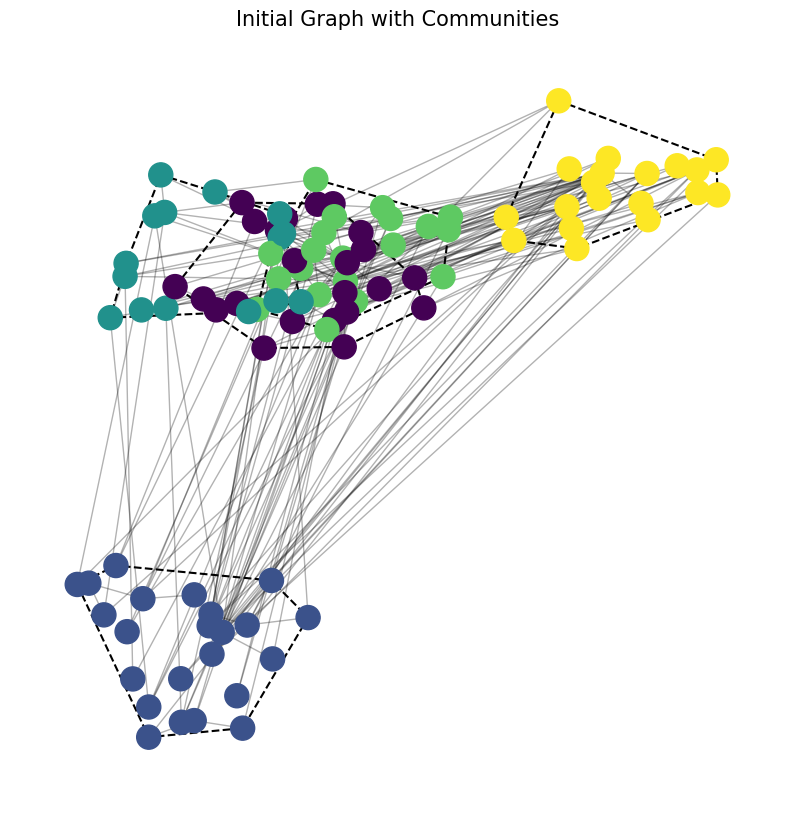

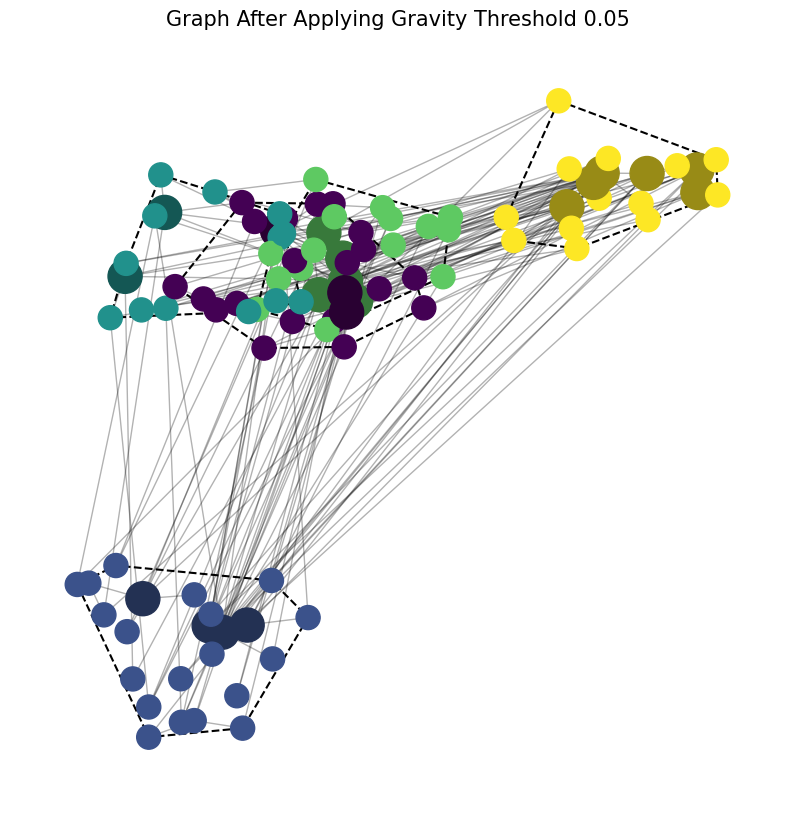

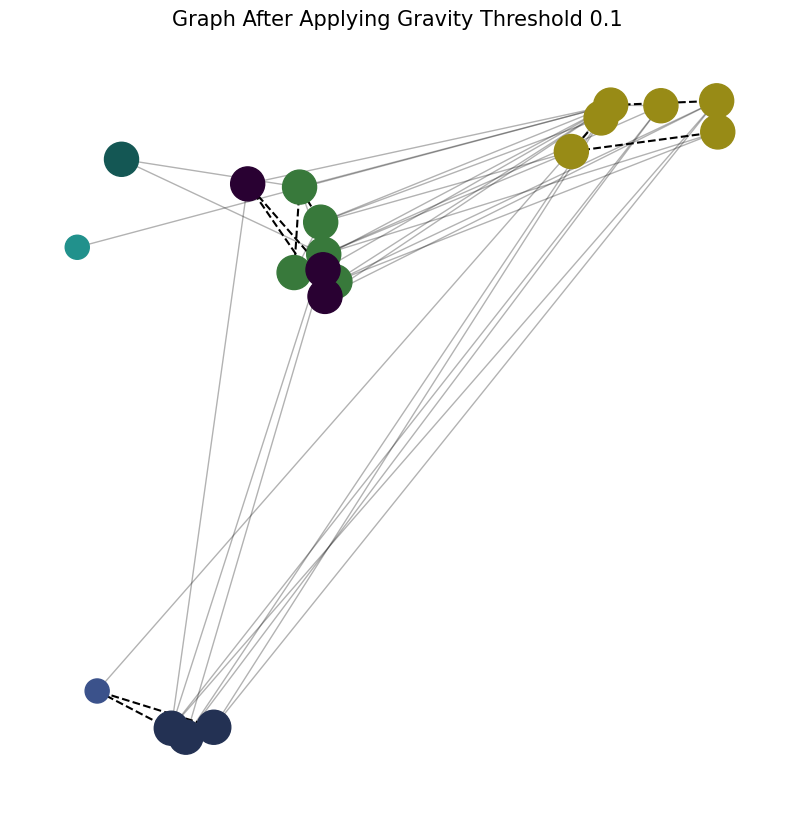

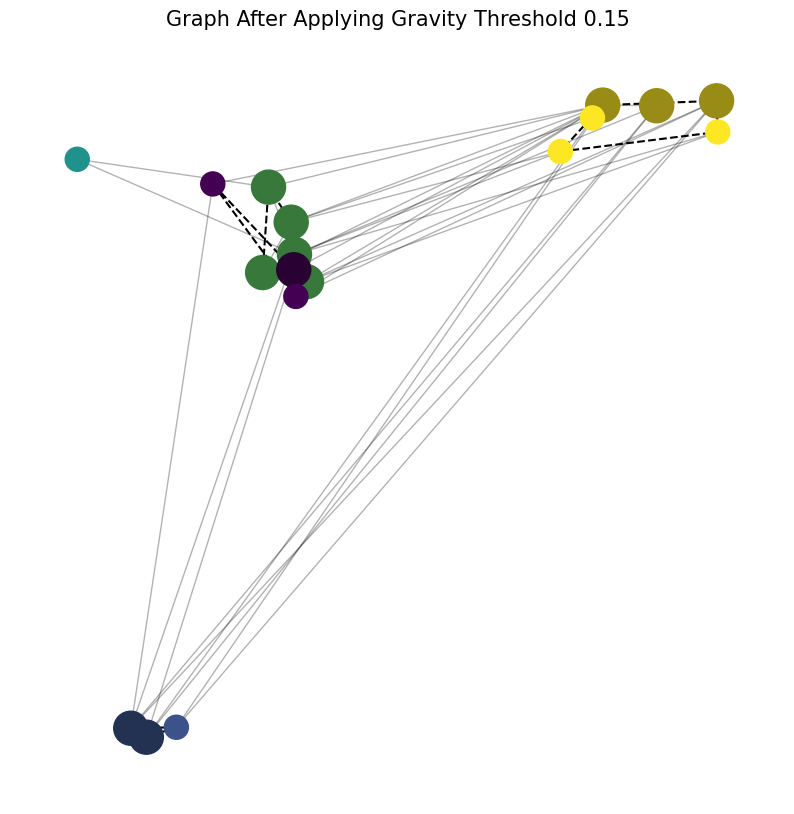

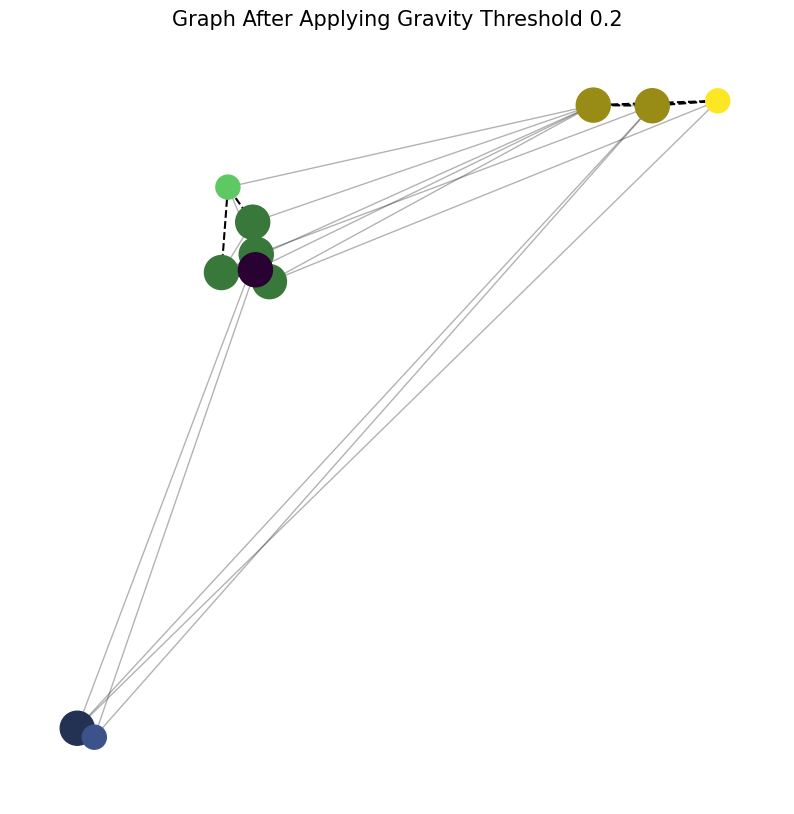

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

# Step 1: Create a random graph with 100 nodes using the Barabási-Albert model
G = nx.barabasi_albert_graph(100, 2)  # 100 nodes, each new node connects to 2 existing nodes

# Step 2: Assign random communities to nodes
communities = {node: random.randint(1, 5) for node in G.nodes()}  # 5 different communities
unique_communities = sorted(set(communities.values()))
num_communities = len(unique_communities)

# Create a mapping from community number to index (0 to num_communities-1)
community_to_index = {community: idx for idx, community in enumerate(unique_communities)}

# Use a colormap to assign colors to communities
color_map = cm.get_cmap('viridis', num_communities)
community_colors = {community: color_map(community_to_index[community] / num_communities)
                    for community in unique_communities}

# Step 3: Calculate centrality (used as gravity measure)
centrality = nx.degree_centrality(G)

# Function to darken a color
def darken_color(color, factor=0.6):
    """
    Darkens an RGB color by the given factor.
    Args:
        color (tuple): RGBA color tuple.
        factor (float): Factor by which to darken the color (0 < factor < 1).
    Returns:
        tuple: Darkened RGBA color tuple.
    """
    return tuple([c * factor for c in color[:3]] + [color[3]])

# Function to separate communities in the plot
def separate_communities_layout(G, communities, scale=3):
    """
    Position nodes in different communities separately, but do it only once.
    """
    pos = nx.spring_layout(G, seed=42)  # Start with a spring layout

    # Get unique communities
    unique_communities = set(communities.values())

    # Define offsets for each community to separate them spatially
    offset_dict = {community: (random.uniform(-scale, scale), random.uniform(-scale, scale))
                   for community in unique_communities}

    # Apply the offset to each node's position based on its community
    for node in G.nodes():
        community = communities[node]
        pos[node] = (pos[node][0] + offset_dict[community][0], pos[node][1] + offset_dict[community][1])

    return pos

# Function to plot the graph with community colors, separated positions, and community boundaries
def plot_graph_with_community_boundaries(G, node_size, node_color, title, pos, communities):
    plt.figure(figsize=(10, 10))

    # Plot the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw a boundary around each community using Convex Hull
    for community in set(communities.values()):
        # Extract the nodes in this community
        community_nodes = [node for node in G.nodes() if communities[node] == community]

        # Get the positions of the community nodes
        points = np.array([pos[node] for node in community_nodes])

        if len(points) > 2:  # ConvexHull needs at least 3 points
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]

            # Create a polygon patch around the convex hull
            polygon = Polygon(hull_points, fill=False, edgecolor='black', linewidth=1.5, linestyle='--')
            plt.gca().add_patch(polygon)

    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Step 4: Compute node positions ONCE
pos = separate_communities_layout(G, communities)  # Compute and reuse these positions

# Plot the graph before applying gravity thresholds
colors = [community_colors[communities[node]] for node in G.nodes()]
node_sizes = [300 for node in G.nodes()]  # Uniform size for the initial plot
plot_graph_with_community_boundaries(G, node_sizes, colors, "Initial Graph with Communities", pos, communities)

# Function to apply gravity threshold and plot the graph
def apply_gravity_threshold_and_plot(G, gravity_threshold, pos, title):
    # Calculate centrality (gravity measure)
    centrality = nx.degree_centrality(G)

    # Identify high gravity nodes
    high_gravity_nodes = {node for node, cent in centrality.items() if cent > gravity_threshold}

    # Prepare colors and node sizes after applying gravity threshold
    colors = []
    for node in G.nodes():
        base_color = community_colors[communities[node]]
        if node in high_gravity_nodes:
            dark_color = darken_color(base_color, factor=0.6)
            colors.append(dark_color)
        else:
            colors.append(base_color)

    node_sizes = [300 if node not in high_gravity_nodes else 600 for node in G.nodes()]  # Larger size for high gravity nodes

    # Plot the graph
    plot_graph_with_community_boundaries(G, node_sizes, colors, title, pos, communities)

    # Remove low gravity nodes (below threshold)
    low_gravity_nodes = {node for node, cent in centrality.items() if cent < gravity_threshold}
    G.remove_nodes_from(low_gravity_nodes)

# Apply gravity thresholds in stages and plot the graph after each step
thresholds = [0.05, 0.10, 0.15, 0.20]  # List of gravity thresholds to progressively apply

for i, threshold in enumerate(thresholds):
    title = f"Graph After Applying Gravity Threshold {threshold}"
    apply_gravity_threshold_and_plot(G, threshold, pos, title)


<ipython-input-39-197ba421a18a>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('viridis', num_communities)


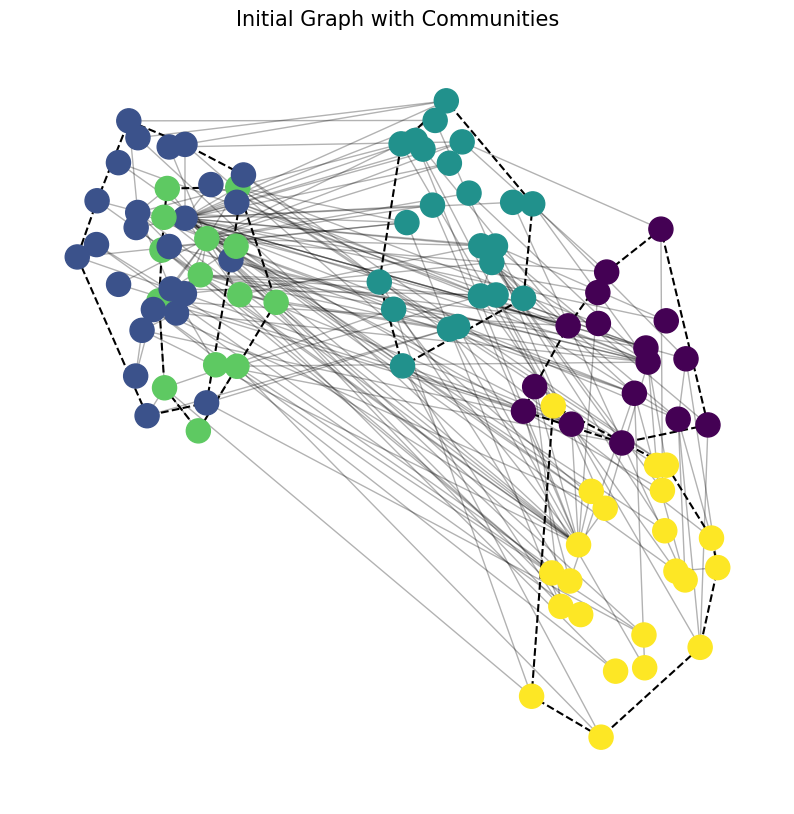

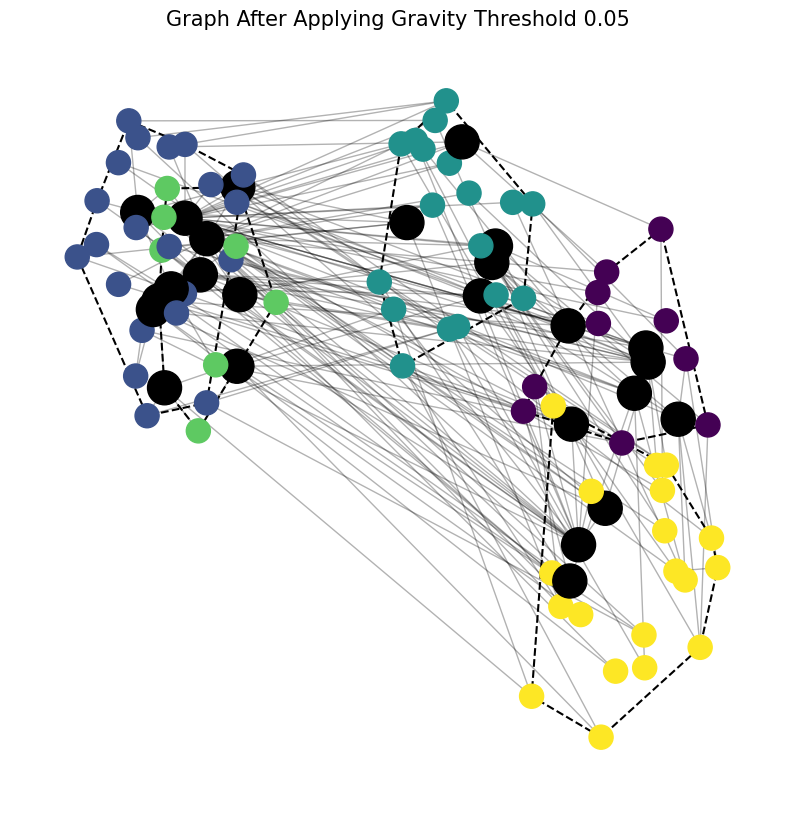

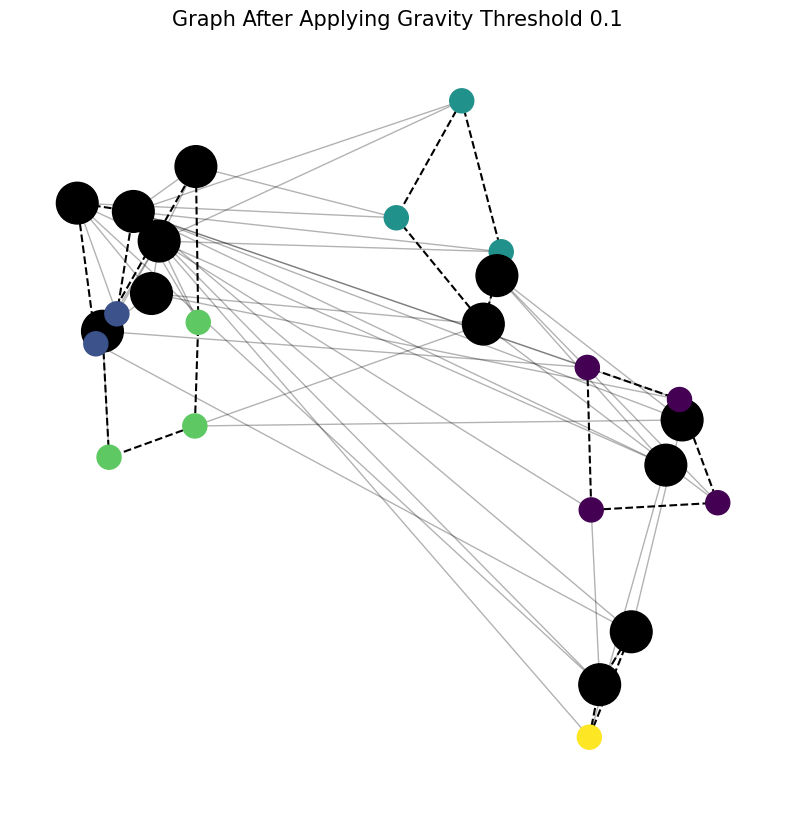

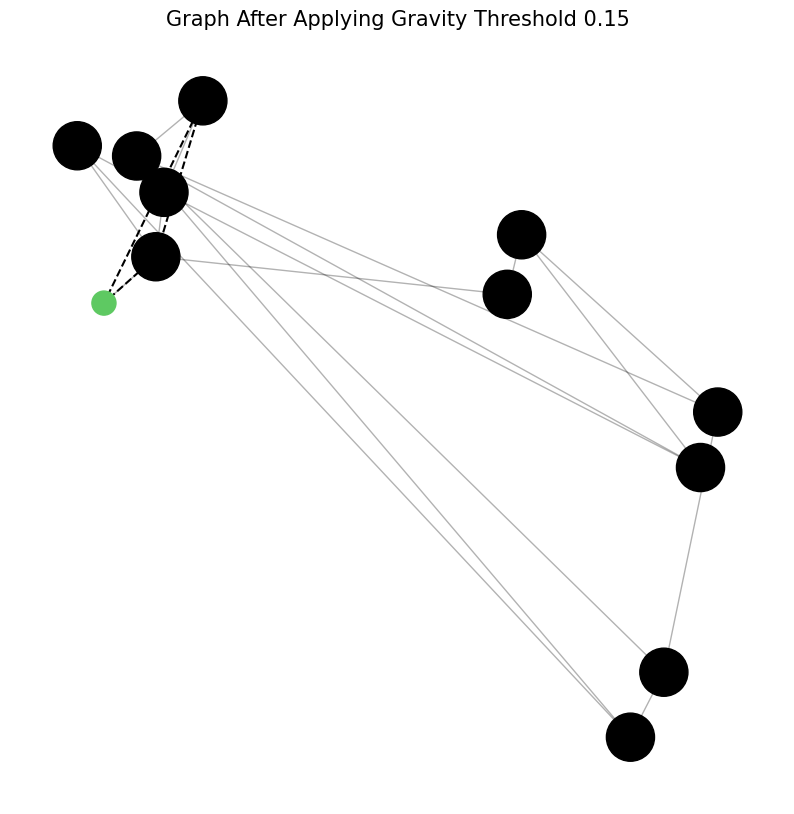

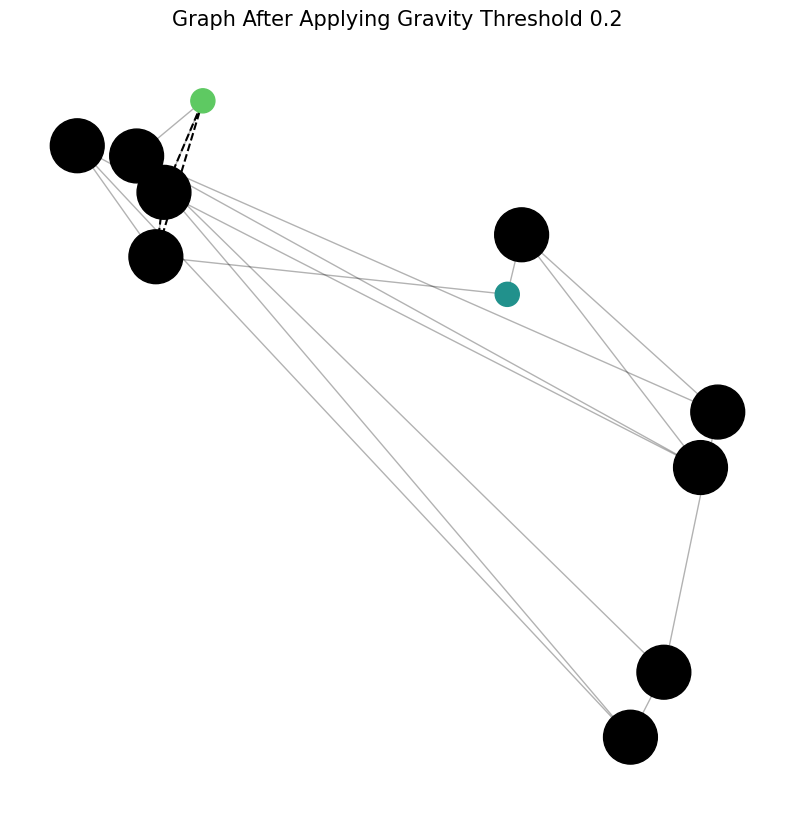

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

# Step 1: Create a random graph with 100 nodes using the Barabási-Albert model
G = nx.barabasi_albert_graph(100, 2)  # 100 nodes, each new node connects to 2 existing nodes

# Step 2: Assign random communities to nodes
communities = {node: random.randint(1, 5) for node in G.nodes()}  # 5 different communities
unique_communities = sorted(set(communities.values()))
num_communities = len(unique_communities)

# Create a mapping from community number to index (0 to num_communities-1)
community_to_index = {community: idx for idx, community in enumerate(unique_communities)}

# Use a colormap to assign colors to communities
color_map = cm.get_cmap('viridis', num_communities)
community_colors = {community: color_map(community_to_index[community] / num_communities)
                    for community in unique_communities}

# Step 3: Calculate centrality (used as gravity measure)
centrality = nx.degree_centrality(G)

# Function to separate communities in the plot
def separate_communities_layout(G, communities, scale=3):
    """
    Position nodes in different communities separately, but do it only once.
    """
    pos = nx.spring_layout(G, seed=42)  # Start with a spring layout

    # Get unique communities
    unique_communities = set(communities.values())

    # Define offsets for each community to separate them spatially
    offset_dict = {community: (random.uniform(-scale, scale), random.uniform(-scale, scale))
                   for community in unique_communities}

    # Apply the offset to each node's position based on its community
    for node in G.nodes():
        community = communities[node]
        pos[node] = (pos[node][0] + offset_dict[community][0], pos[node][1] + offset_dict[community][1])

    return pos

# Function to plot the graph with community colors, separated positions, and community boundaries
def plot_graph_with_community_boundaries(G, node_size, node_color, title, pos, communities):
    plt.figure(figsize=(10, 10))

    # Plot the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw a boundary around each community using Convex Hull
    for community in set(communities.values()):
        # Extract the nodes in this community
        community_nodes = [node for node in G.nodes() if communities[node] == community]

        # Get the positions of the community nodes
        points = np.array([pos[node] for node in community_nodes])

        if len(points) > 2:  # ConvexHull needs at least 3 points
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]

            # Create a polygon patch around the convex hull
            polygon = Polygon(hull_points, fill=False, edgecolor='black', linewidth=1.5, linestyle='--')
            plt.gca().add_patch(polygon)

    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Step 4: Compute node positions ONCE
pos = separate_communities_layout(G, communities)  # Compute and reuse these positions

# Plot the graph before applying gravity thresholds
colors = [community_colors[communities[node]] for node in G.nodes()]
node_sizes = [300 for node in G.nodes()]  # Uniform size for the initial plot
plot_graph_with_community_boundaries(G, node_sizes, colors, "Initial Graph with Communities", pos, communities)

# Function to apply gravity threshold and plot the graph
def apply_gravity_threshold_and_plot(G, gravity_threshold, pos, title, black_hole_growth_factor=1.0):
    # Calculate centrality (gravity measure)
    centrality = nx.degree_centrality(G)

    # Identify high gravity nodes
    high_gravity_nodes = {node for node, cent in centrality.items() if cent > gravity_threshold}

    # Prepare colors and node sizes after applying gravity threshold
    colors = []
    for node in G.nodes():
        if node in high_gravity_nodes:
            colors.append('black')  # Make black holes black
        else:
            colors.append(community_colors[communities[node]])  # Keep other nodes with community color

    # Increase size of black holes progressively
    node_sizes = [300 if node not in high_gravity_nodes else 600 * black_hole_growth_factor for node in G.nodes()]

    # Plot the graph
    plot_graph_with_community_boundaries(G, node_sizes, colors, title, pos, communities)

    # Remove low gravity nodes (below threshold)
    low_gravity_nodes = {node for node, cent in centrality.items() if cent < gravity_threshold}
    G.remove_nodes_from(low_gravity_nodes)

# Apply gravity thresholds in stages and plot the graph after each step
thresholds = [0.05, 0.10, 0.15, 0.20]  # List of gravity thresholds to progressively apply

for i, threshold in enumerate(thresholds):
    title = f"Graph After Applying Gravity Threshold {threshold}"
    # Increase the size of black holes progressively in each step (e.g., 1.0x, 1.5x, 2.0x)
    apply_gravity_threshold_and_plot(G, threshold, pos, title, black_hole_growth_factor=1.0 + i * 0.5)
